# KEN1435 - Principles of Data Science | Homework Assignment 3 (HA3) :  Societal Mood

For this assignment, we will reconsider the data set that is extracted from social media. As previously introduced, it covers a collection of users on social media that were retrieved based on posts that referenced a list of keywords related to the COVID-19 pandemic. Among all messages acquired with these keywords, those users were extacted that indicated their location was a city in the Netherlands. Specifically, we take a look at the accounts that specified "Maastricht" as their location.

First we load the necessary python packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

tab10 = plt.get_cmap("tab10").colors

### Exercise 1. (*1pt*)
Load the data set as provided in the files `users_HA3.tsv` and `tweets_HA3.tsv` into the variables `users` and `tweets`, respectively. Make sure that you convert the times at which the tweets are created from strings into a usable format.

#### Solution

In [2]:
users = pd.read_csv("users_HA3.tsv", sep="\t")
tweets = pd.read_csv("tweets_HA3.tsv", sep="\t")

tweets['created_at'] = pd.to_datetime(tweets['created_at'])

print("Users data:")
print(users.head())
print("\nTweets data:")
print(tweets.head())

pd.set_option('display.width', 1000)

Users data:
  Unnamed: 0  gender gender.1    twitter twitter.1
0        NaN    male   female  followers   friends
1    user_id     NaN      NaN        NaN       NaN
2   043u0001  0.9428   0.0572        733       894
3   043u0003  0.9649   0.0351         92       647
4   043u0006  0.7454   0.2546        276       278

Tweets data:
      tweet_id   user_id                created_at  ANEW_Arousal  \
0  043t0000000  043u0001 2020-04-23 12:45:58+00:00      4.171667   
1  043t0000001  043u0001 2020-04-23 11:28:08+00:00      3.533333   
2  043t0000002  043u0001 2020-04-23 11:19:08+00:00           NaN   
3  043t0000003  043u0001 2020-04-22 22:31:24+00:00           NaN   
4  043t0000004  043u0001 2020-04-22 15:06:45+00:00      3.300000   

   ANEW_Dominance  ANEW_Valence  
0        4.226667      4.236667  
1        3.986667      3.940000  
2             NaN           NaN  
3             NaN           NaN  
4        4.030000      4.310000  


## Differences between male and female accounts
When processing the accounts that were collected in the data gathering phase, the researchers also analyzed the profile pages of the accounts using a gender classifier. The file `users_HA3.tsv` contains the outcomes of this classification. For each account, the classifier outputs a probability that an account would be classified with either label.

The researchers want to analyze the difference in expressed mood between male and female accounts. They decide that they will use a cut-off at a probability of `0.8` as an inclusion criterium. So if an account scores more than `0.8` on either male or female probability, it is included in that group for further analysis.

### Exercise 2. (*3pt*)
Visualize the ANEW Valence distribution of all tweets from the accounts that are classified as male and female.

#### Solution

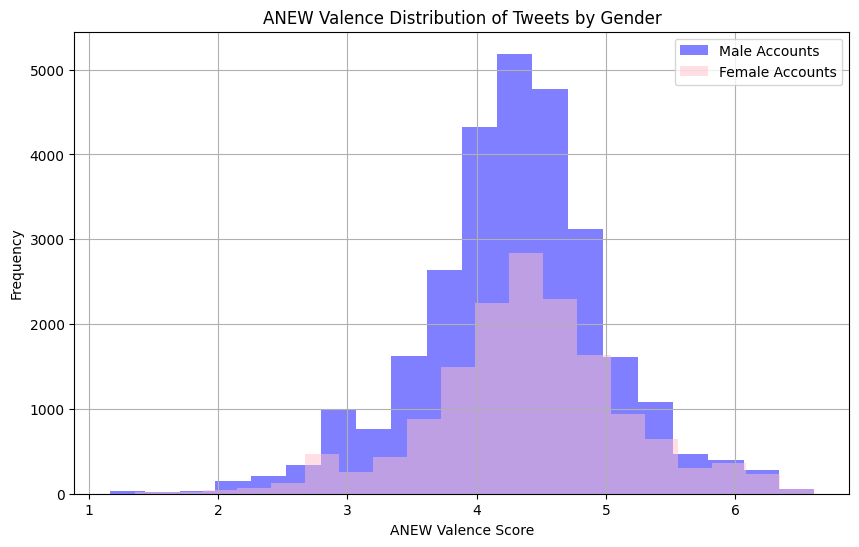

In [14]:
users['gender'] = pd.to_numeric(users['gender'], errors='coerce')
users['gender.1'] = pd.to_numeric(users['gender.1'], errors='coerce')

male_accounts = users[users['gender'] > 0.8]
female_accounts = users[users['gender.1'] > 0.8]

male_tweets = pd.merge(male_accounts, tweets, left_on='Unnamed: 0', right_on='user_id')
female_tweets = pd.merge(female_accounts, tweets, left_on='Unnamed: 0', right_on='user_id')

plt.figure(figsize=(10, 6))
plt.hist(male_tweets['ANEW_Valence'].dropna(), bins=20, alpha=0.5, color='blue', label='Male Accounts')
plt.hist(female_tweets['ANEW_Valence'].dropna(), bins=20, alpha=0.5, color='pink', label='Female Accounts')
plt.title('ANEW Valence Distribution of Tweets by Gender')
plt.xlabel('ANEW Valence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Based on the visual comparison above, the researchers want to determine whether the male and female averages align. Therefore, they run a one sided statistical test.

### Exercise 3. (*2pt*)
Denote the null-hypothesis and alternative hypothesis for this test.

#### Solution

- $H_0$ (null-hypothesis): The average ANEW Valence of tweets from male accounts is equal to or less than the average ANEW Valence of tweets from female accounts.
- $H_a$ (alternative hypothesis): The average ANEW Valence of tweets from male accounts is greater than the average ANEW Valence of tweets from female accounts.

Suppose that we may assume that the average ANEW Valence score for female accounts follows a normal distribution. We determine the mean and standard deviation of the distribution directly from the data.

### Exercise 4. (*2pt*)
Determine the value of the test-statictic and the $P$-value.

#### Solution

In [31]:
def t_distribution(x, df):
    return (1 / (np.sqrt(2 * np.pi * df)) * (1 + (x ** 2) / df) ** (-0.5 * (df + 1)))

female_valence_mean = female_tweets['ANEW_Valence'].mean()
female_valence_std = female_tweets['ANEW_Valence'].std()

n_male = len(male_tweets['ANEW_Valence'].dropna())
n_female = len(female_tweets['ANEW_Valence'].dropna())

std_error_diff = np.sqrt((female_valence_std**2 / n_female) + (male_tweets['ANEW_Valence'].std()**2 / n_male))

t_statistic = (male_tweets['ANEW_Valence'].mean() - female_valence_mean) / std_error_diff

df = min(n_male - 1, n_female - 1)

p_value = 1 - t_distribution(t_statistic, df)

print("Test statistic:", t_statistic)
print("P-value:", p_value)


Test statistic: -14.856082217437036
P-value: 1.0


## Response to COVID-19
To assess each accounts reaction to the start of the COVID-19 pandemic, we will investigate the difference the average ANEW Valence in the month before the first COVID-19 case was observed in the Netherlands (i.e., December 2019) and a month after (i.e., March 2020).

### Exercise 5. (*2pt*)
Which accounts have the biggest and lowest difference in average ANEW Valence across these two months?

#### Solution

In [33]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

dec_tweets = tweets[(tweets['created_at'].dt.year == 2019) & (tweets['created_at'].dt.month == 12)]
mar_tweets = tweets[(tweets['created_at'].dt.year == 2020) & (tweets['created_at'].dt.month == 3)]

dec_avg_valence = dec_tweets.groupby('user_id')['ANEW_Valence'].mean()
mar_avg_valence = mar_tweets.groupby('user_id')['ANEW_Valence'].mean()

difference = mar_avg_valence - dec_avg_valence

max_diff_account = difference.idxmax()
min_diff_account = difference.idxmin()

max_diff_value = difference[max_diff_account]
min_diff_value = difference[min_diff_account]

print("Account with the biggest difference in average ANEW Valence:", max_diff_account)
print("Difference value:", max_diff_value)

print("Account with the lowest difference in average ANEW Valence:", min_diff_account)
print("Difference value:", min_diff_value)


Account with the biggest difference in average ANEW Valence: 043u0063
Difference value: 1.893441964285714
Account with the lowest difference in average ANEW Valence: 043u0021
Difference value: -0.9036666666666671
